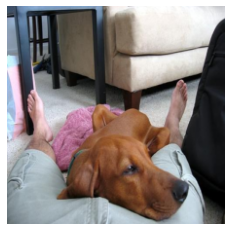

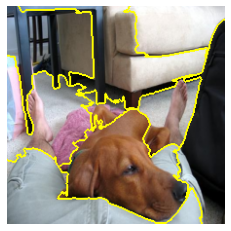

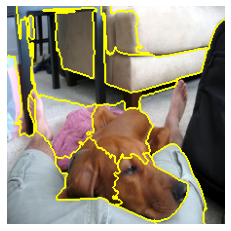

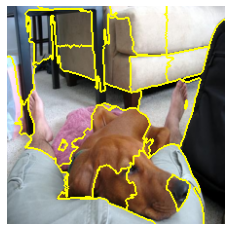

In [21]:
# import the necessary packages
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import torchvision
import torch
import random
import torch.nn as nn
import litdata
from skimage.filters import sobel
from skimage.color import rgb2gray


postprocess = (
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)), 
        #torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    nn.Identity(),
    )

train_dataset = litdata.LITDataset(
            "IN1k",
            r"F:\data",
            override_extensions=[
                'jpg',
                'cls'
            ],
            train = True,
        ).map_tuple(*postprocess)

# Load CIFAR-10 dataset
#train_dataset = torchvision.datasets.CIFAR10(root='F:\data', train=True, download=False, transform=torchvision.transforms.Resize((224, 224)))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Select a random image from the data loader
random_index = 3#random.randint(0, len(train_dataset) - 1)
image, _ = train_dataset[random_index]

# Convert the image to a floating point data type
image = img_as_float(image)

plt.imshow(image)
plt.axis("off")
plt.show()

gradient = sobel(rgb2gray(image))

# Loop over the number of segments
for numMarkers in (10, 20, 30):
    # Apply SLIC and extract (approximately) the supplied number of segments
    segments_watershed = watershed(gradient, markers=numMarkers, compactness=0.001)
    
    # Show the output of SLIC
    fig = plt.figure("Superpixels -- %d numMarkers" % (numMarkers))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments_watershed))
    plt.axis("off")

# Show the plots
plt.show()

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


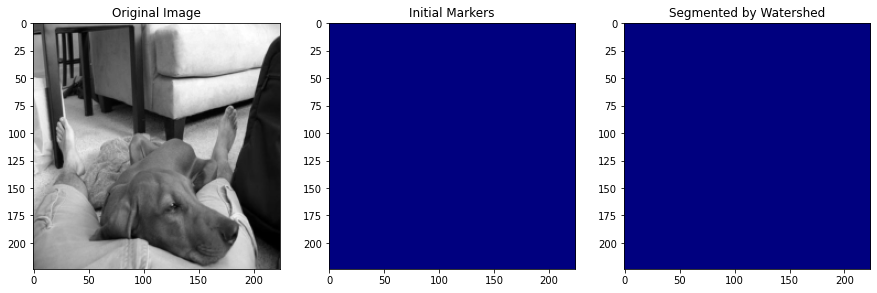

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import label, generate_binary_structure, binary_dilation


def generate_synthetic_image():
    """ Generate a simple synthetic grayscale image with different intensity regions. """
    image = np.zeros((200, 200), dtype=np.uint8)
    cv2.rectangle(image, (50, 50), (150, 150), 100, -1)  # Mid-tone square
    cv2.rectangle(image, (70, 70), (130, 130), 200, -1)  # Brighter inner square
    return image

def init_markers(image):
    """ Initialize markers for the watershed algorithm. """
    markers = np.zeros_like(image)
    markers[image < 50] = 1
    markers[image > 150] = 2
    return markers

def watershed(image, markers):
    """ A very simplified watershed algorithm implemented from scratch. """
    from scipy.ndimage import label, generate_binary_structure
    structure = generate_binary_structure(2, 2)

    old_regions = np.zeros_like(image)
    while True:
        # Label regions
        labeled_array, num_features = label(markers > 0, structure=structure)
        if np.array_equal(labeled_array, old_regions):
            break
        old_regions = labeled_array.copy()

        # Expand regions by one pixel
        for label_idx in range(1, num_features + 1):
            mask = labeled_array == label_idx
            dilated = binary_dilation(mask, structure=structure)
            conflict_zones = np.logical_and(dilated, markers == 0)
            markers[conflict_zones] = label_idx
    
    return labeled_array


postprocess = (
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        #torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    nn.Identity(),
    )

train_dataset = litdata.LITDataset(
            "IN1k",
            r"F:\data",
            override_extensions=[
                'jpg',
                'cls'
            ],
            train = True,
        ).map_tuple(*postprocess)

# Load CIFAR-10 dataset
#train_dataset = torchvision.datasets.CIFAR10(root='F:\data', train=True, download=False, transform=torchvision.transforms.Resize((224, 224)))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Select a random image from the data loader
random_index = 3#random.randint(0, len(train_dataset) - 1)
image, _ = train_dataset[random_index]

# Convert the image to a floating point data type
image = img_as_float(image)

markers = init_markers(image)
result = watershed(image, markers)

print(result)

# Display the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image, cmap='gray'), ax[0].title.set_text('Original Image')
ax[1].imshow(markers, cmap='jet'), ax[1].title.set_text('Initial Markers')
ax[2].imshow(result, cmap='jet'), ax[2].title.set_text('Segmented by Watershed')
plt.show()

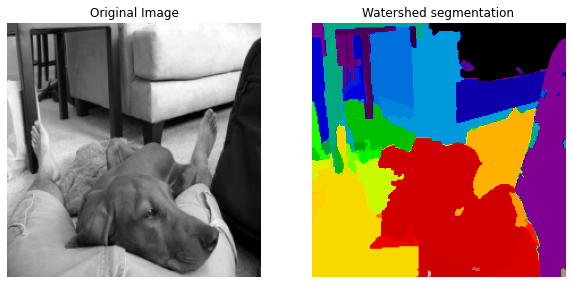

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import sobel

def watershed_from_scratch(image):
    # Convert image to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel(image)

    # Generate markers
    markers = np.zeros_like(image)
    markers[image < np.percentile(image, 10)] = 1
    markers[image > np.percentile(image, 90)] = 2

    # Simulate flooding process
    from scipy.ndimage import label, generate_binary_structure
    labeled, _ = label(markers)
    
    structure = generate_binary_structure(2, 2)

    import heapq
    heap = []
    for (i, j), value in np.ndenumerate(labeled):
        if value > 0:
            heapq.heappush(heap, (gradient[i, j], i, j, value))
    
    while heap:
        h, i, j, label_val = heapq.heappop(heap)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                    if labeled[ni, nj] == 0:
                        labeled[ni, nj] = label_val
                        heapq.heappush(heap, (gradient[ni, nj], ni, nj, label_val))


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Watershed segmentation')
    plt.axis('off')
    
    plt.show()


watershed_from_scratch(image)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DifferentiableWatershed(nn.Module):
    def __init__(self, height, width):
        super(DifferentiableWatershed, self).__init__()
        # Initialize the marker positions (learnable parameter)
        self.markers = nn.Parameter(torch.rand(1, 1, height, width), requires_grad=True)

    def forward(self, x):
        # Apply a soft distance transform
        soft_dist = 1 - torch.sigmoid(self.markers)  # Sigmoid for a smooth transition

        # Compute gradients on input image to guide the regions expansion
        # Ensure padding is set to maintain the input dimensions
        grad_x = torch.abs(F.conv2d(x, torch.tensor([[[[-1, 0, 1]]]], dtype=torch.float32), padding=(0, 1)))
        grad_y = torch.abs(F.conv2d(x, torch.tensor([[[[-1], [0], [1]]]], dtype=torch.float32), padding=(1, 0)))
        image_gradient = grad_x + grad_y

        # Combine the soft distance transform with the image gradients
        modified_distance = soft_dist * torch.exp(-image_gradient)  # Exponential to enhance high gradient regions

        # Normalize the results to simulate region growing
        segmented_output = F.softmax(modified_distance, dim=-1)
        return segmented_output

# Example usage:
# Initialize module
height, width = 128, 128  # Example dimensions
model = DifferentiableWatershed(height, width)
# Dummy input image
# Forward pass
segmentation = model(image)
segmentation